# COMS21202: Symbols, Patterns and Signals #
**CW1**: *This marked assignment has 3 parts to be undertaken in weeks 17-19 with students working in pairs.*

In [92]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy import stats
import matplotlib.pyplot as plt


%matplotlib inline
# notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

## Objectives ##
The goal of this assignment is for you to gain experience with clustering and classifying data. You will be given two sets of data points, each containing values for 5 different attributes (features) derived from an unspecified number of different object classes. One set contains 150 points and you should use it to *train* your classifier. The second set contains 15 points and you should use it to *test* your classifier. A complication is that the training set is **not** labelled - you will need to analyse the feature values, identify two features which are able to separate the different object classes and then cluster the points to obtain class labels which can then be used to train a classifier.

The steps that you should follow are detailed below. You will need to become familiar with several new `Python` commands and so we advise that you make use of the `Python` help facility. You will each be given different data files, with different attribute values, different class parameters and different distinguishing features. Your results will therefore not be the same as that of other students. For those working in pairs you will have to carry out the work for both data sets and be able to explain the differences obtained.

## CW1a (week 17) ##
### 1. ###
Collect your training and test data from [here](https://www.cs.bris.ac.uk/Teaching/Resources/COMS21202/cw1/index.jsp). You then need to identify which two features separate the classes in your training data. The best way of doing this is to visualise the data by plotting the attribute values for each pair of features. Use the `np.loadtxt` command to read in the data and the plotting commands (try `plotmatrix`) to plot attribute values against each other. Visually inspect the results to understand the data and argue which features best separate the classes. Once you identified the two features create a new data matrix `X` holding only those features as columns.

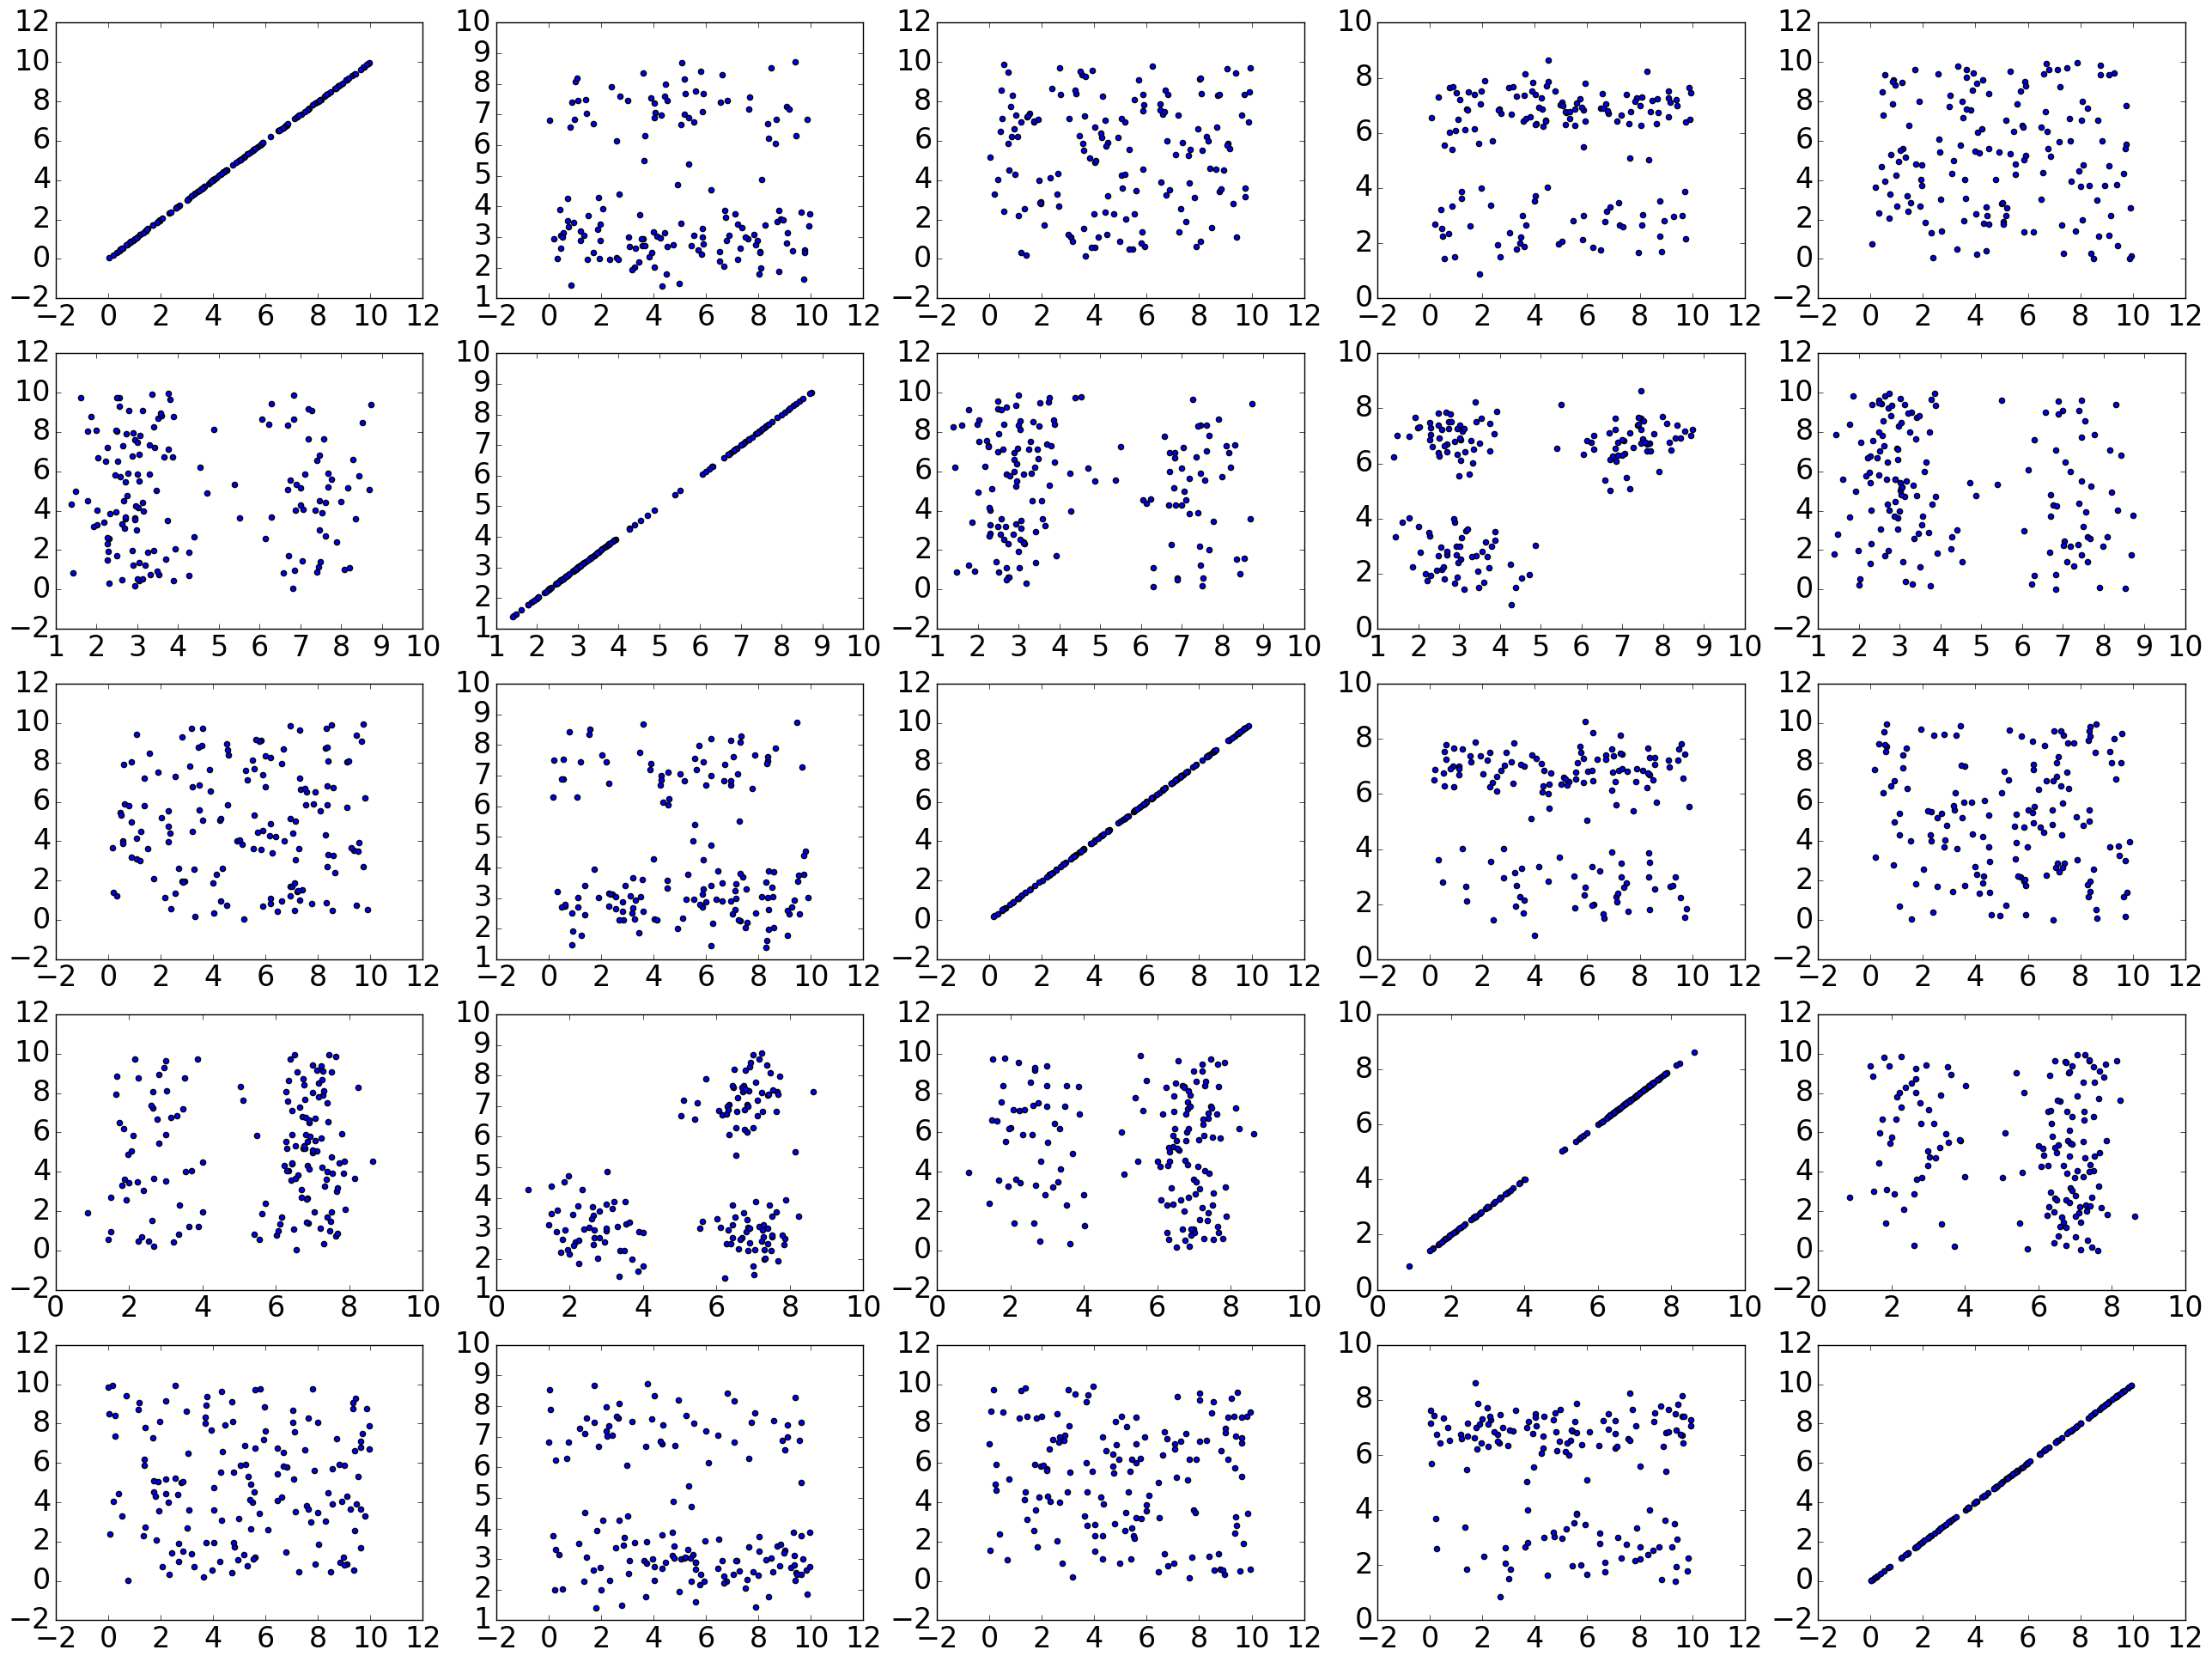

In [93]:
# Define colour and marker arrays to reference when plotting
COLOURS = ['blue', 'red', 'green', 'black', 'yellow', 'organe', 'cyan', 'purple']
MARKERS = np.array(['o', '+'])

'''Plots every feature against every other'''
def plotmatrix(Matrix):
  r, c = Matrix.shape
  fig = plt.figure()
  plotID = 1
  for i in range(c):
    for j in range(c):
      ax = fig.add_subplot( c, c, plotID )
      ax.scatter( Matrix[:,i], Matrix[:,j] )
      plotID += 1
  plt.show()

# Load training data and plot features against one another
train_data = np.loadtxt('cw1data.train.example.txt') # TODO Change to real data
plotmatrix(train_data)

SELECTED_FEATURES = (1, 3) # TODO Change
NUM_OF_CLUSTERS = 3 # TODO Change

# Store only selected columns in X
X = train_data[:,SELECTED_FEATURES]

### Your comments ###

TODO: Redo this with actuall data

The plot using featuers in columns 1 and 3 seperates the data into three groupings. The groups are less sparse compared with the other plots. The seperation between the groups are larger then in other plots.

### 2. ###
You now need to derive class labels for each of the data points in the training data. You can do this automatically using the K-means algorithm applied to `X`, where *K* is the number of classes you identified in the previous step. Use the function `kmeans` to do this. Next, you want to visualise the outcome of the K-means clustering. One way to do this is to plot each cluster found by K-means in a different colour. To this end, use the vector of cluster indices returned by `kmeans` to store the points for each class in separate matrices by means of the `np.where` command.

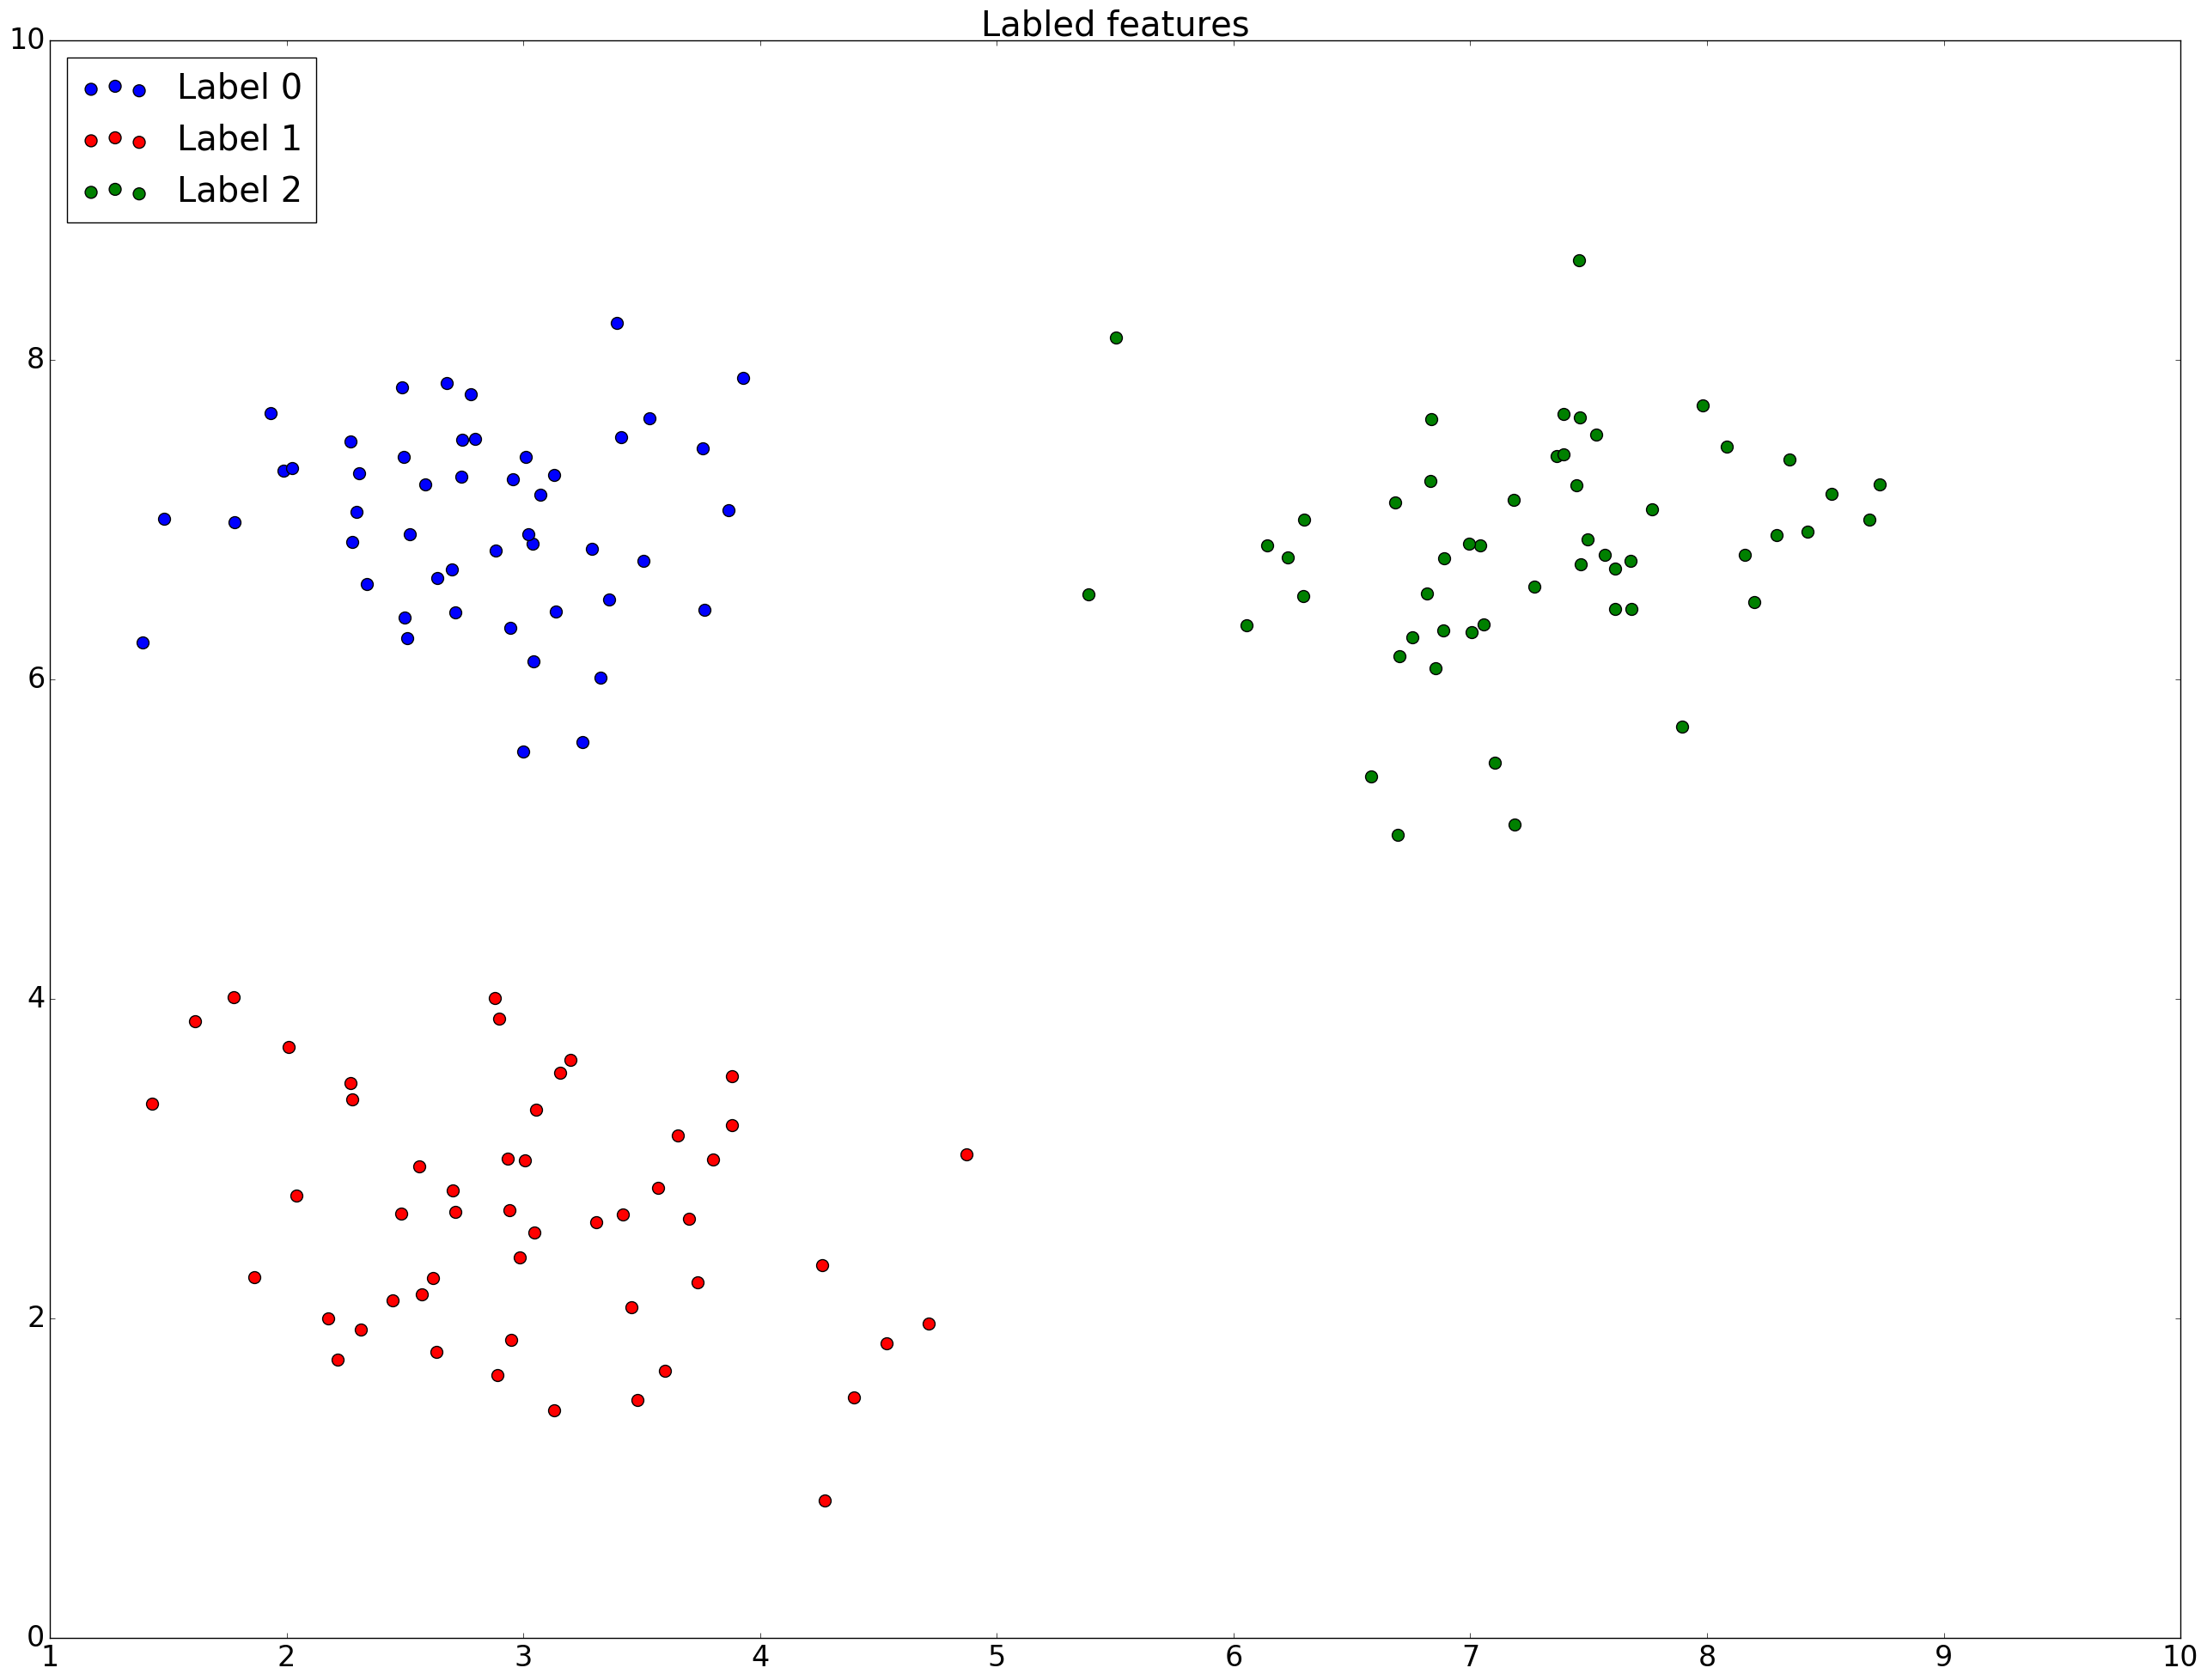

In [94]:
def kmeans(Data, NClusters):
  km = KMeans(NClusters)
  fitted = km.fit(Data)
  return (fitted.cluster_centers_, fitted.labels_, fitted.inertia_)

def split_labels(Data, labels):
    labled_data = {}
    for label in np.unique(labels):
        labled_data[label] = np.take(Data, np.where(labels == label), axis=0)[0]
        
    return labled_data

# Apply kmeans
X_cluster_centers, X_labels, X_inertia = kmeans(X, NUM_OF_CLUSTERS)

X_labeld = split_labels(X, X_labels)

# Plot each label 
fig_train, ax_train = plt.subplots()
for label, P in X_labeld.items():
    ax_train.scatter(P[:,0], P[:,1], c=COLOURS[label], s=100, label='Label %i' % label)
    
plt.title('Labled features')
plt.legend(loc='upper left')    
plt.show()


### Your comments ###

Put here any comments

### 3. ###
The centroids found by K-means can now be used as a simple nearest-neighbour classifier. Load your test data and select the two relevant features. Using a combination of the `cdist(X, metric='euclidean', p=2)` and `np.argmin` (with `axis` parameter) commands, construct a vector of labels for each of the test points indicating which cluster centroid is the nearest. Plot the test points in the previous plot with the colour indicating their class but a different symbol. The corresponding decision boundaries can be plotted by passing the centroids to the `Voronoi` and `voronoi_plot_2d` functions (remember to set the `ax` parameter of the later one to your current plot).

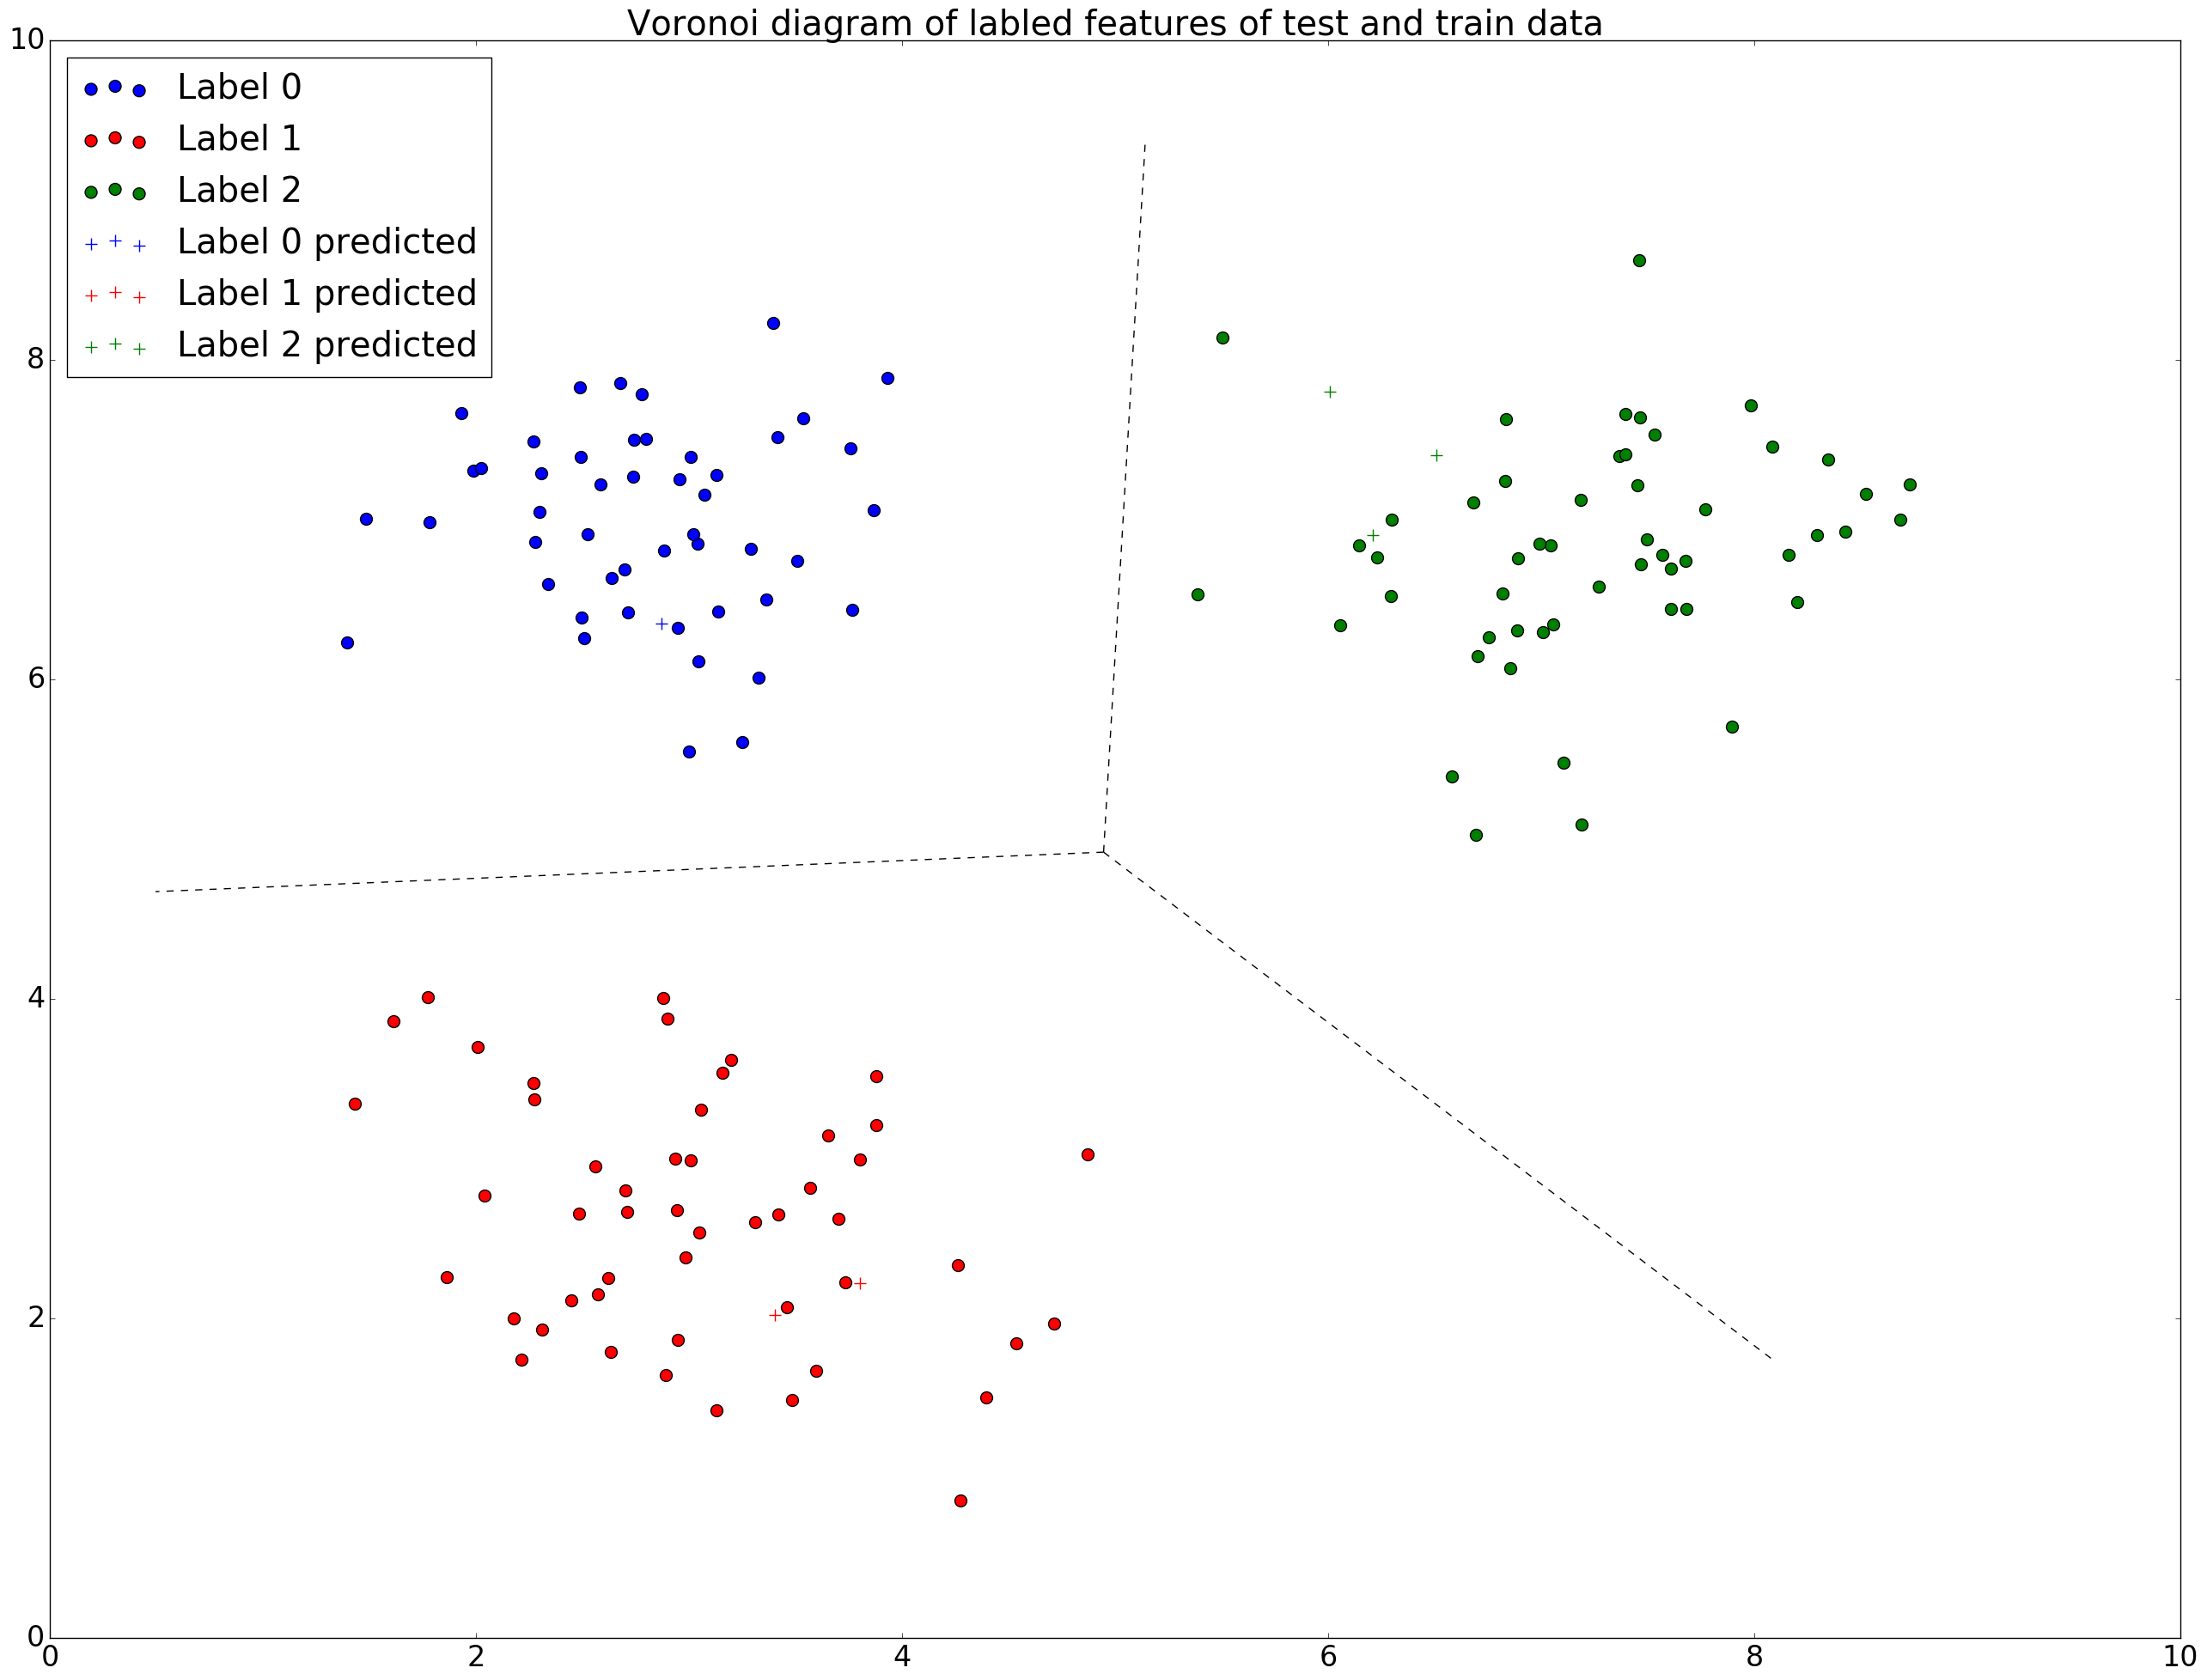

In [293]:
# Load test data, Y is only selected features
test_data = np.loadtxt('cw1data.test.example.txt') # TODO Change to real data
Y = test_data[:,SELECTED_FEATURES]

# Classify points - find nearest cluster centre
Y_labels = np.argmin(cdist(X_cluster_centers, Y, metric='euclidean', p=2), axis=0)

Y_labeld = split_labels(Y, Y_labels)

fig, ax = plt.subplots()

# Add voronoi diagrams
vor = Voronoi(X_cluster_centers)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='black')

# Plot each test and train sets with coloured labels and different markers
for label, P in X_labeld.items():
    ax.scatter(P[:,0], P[:,1], marker='o', c=COLOURS[label], s=100, label='Label %i' % label)
    
for label, P in Y_labeld.items():
    ax.scatter(P[:,0], P[:,1], marker='+', c=COLOURS[label], s=100, label='Label %i predicted' % label)
    
plt.autoscale(True, tight=False)        
plt.title('Voronoi diagram of labled features of test and train data')
plt.legend(loc='upper left')

plt.show()



### Your comments ###

Put here any comments

### 4. ###
Finally, we want you to deliberately find a non-optimal clustering. To this end, use the within-cluster sums of point-to-centroid distances returned by K-means to keep calling K-means until you find a clearly non-optimal value. You may need to change the definition of `kmeans` function and play around with its initialisation parameters. Plot the Voronoi diagram in the same plot to demonstrate non-optimality.

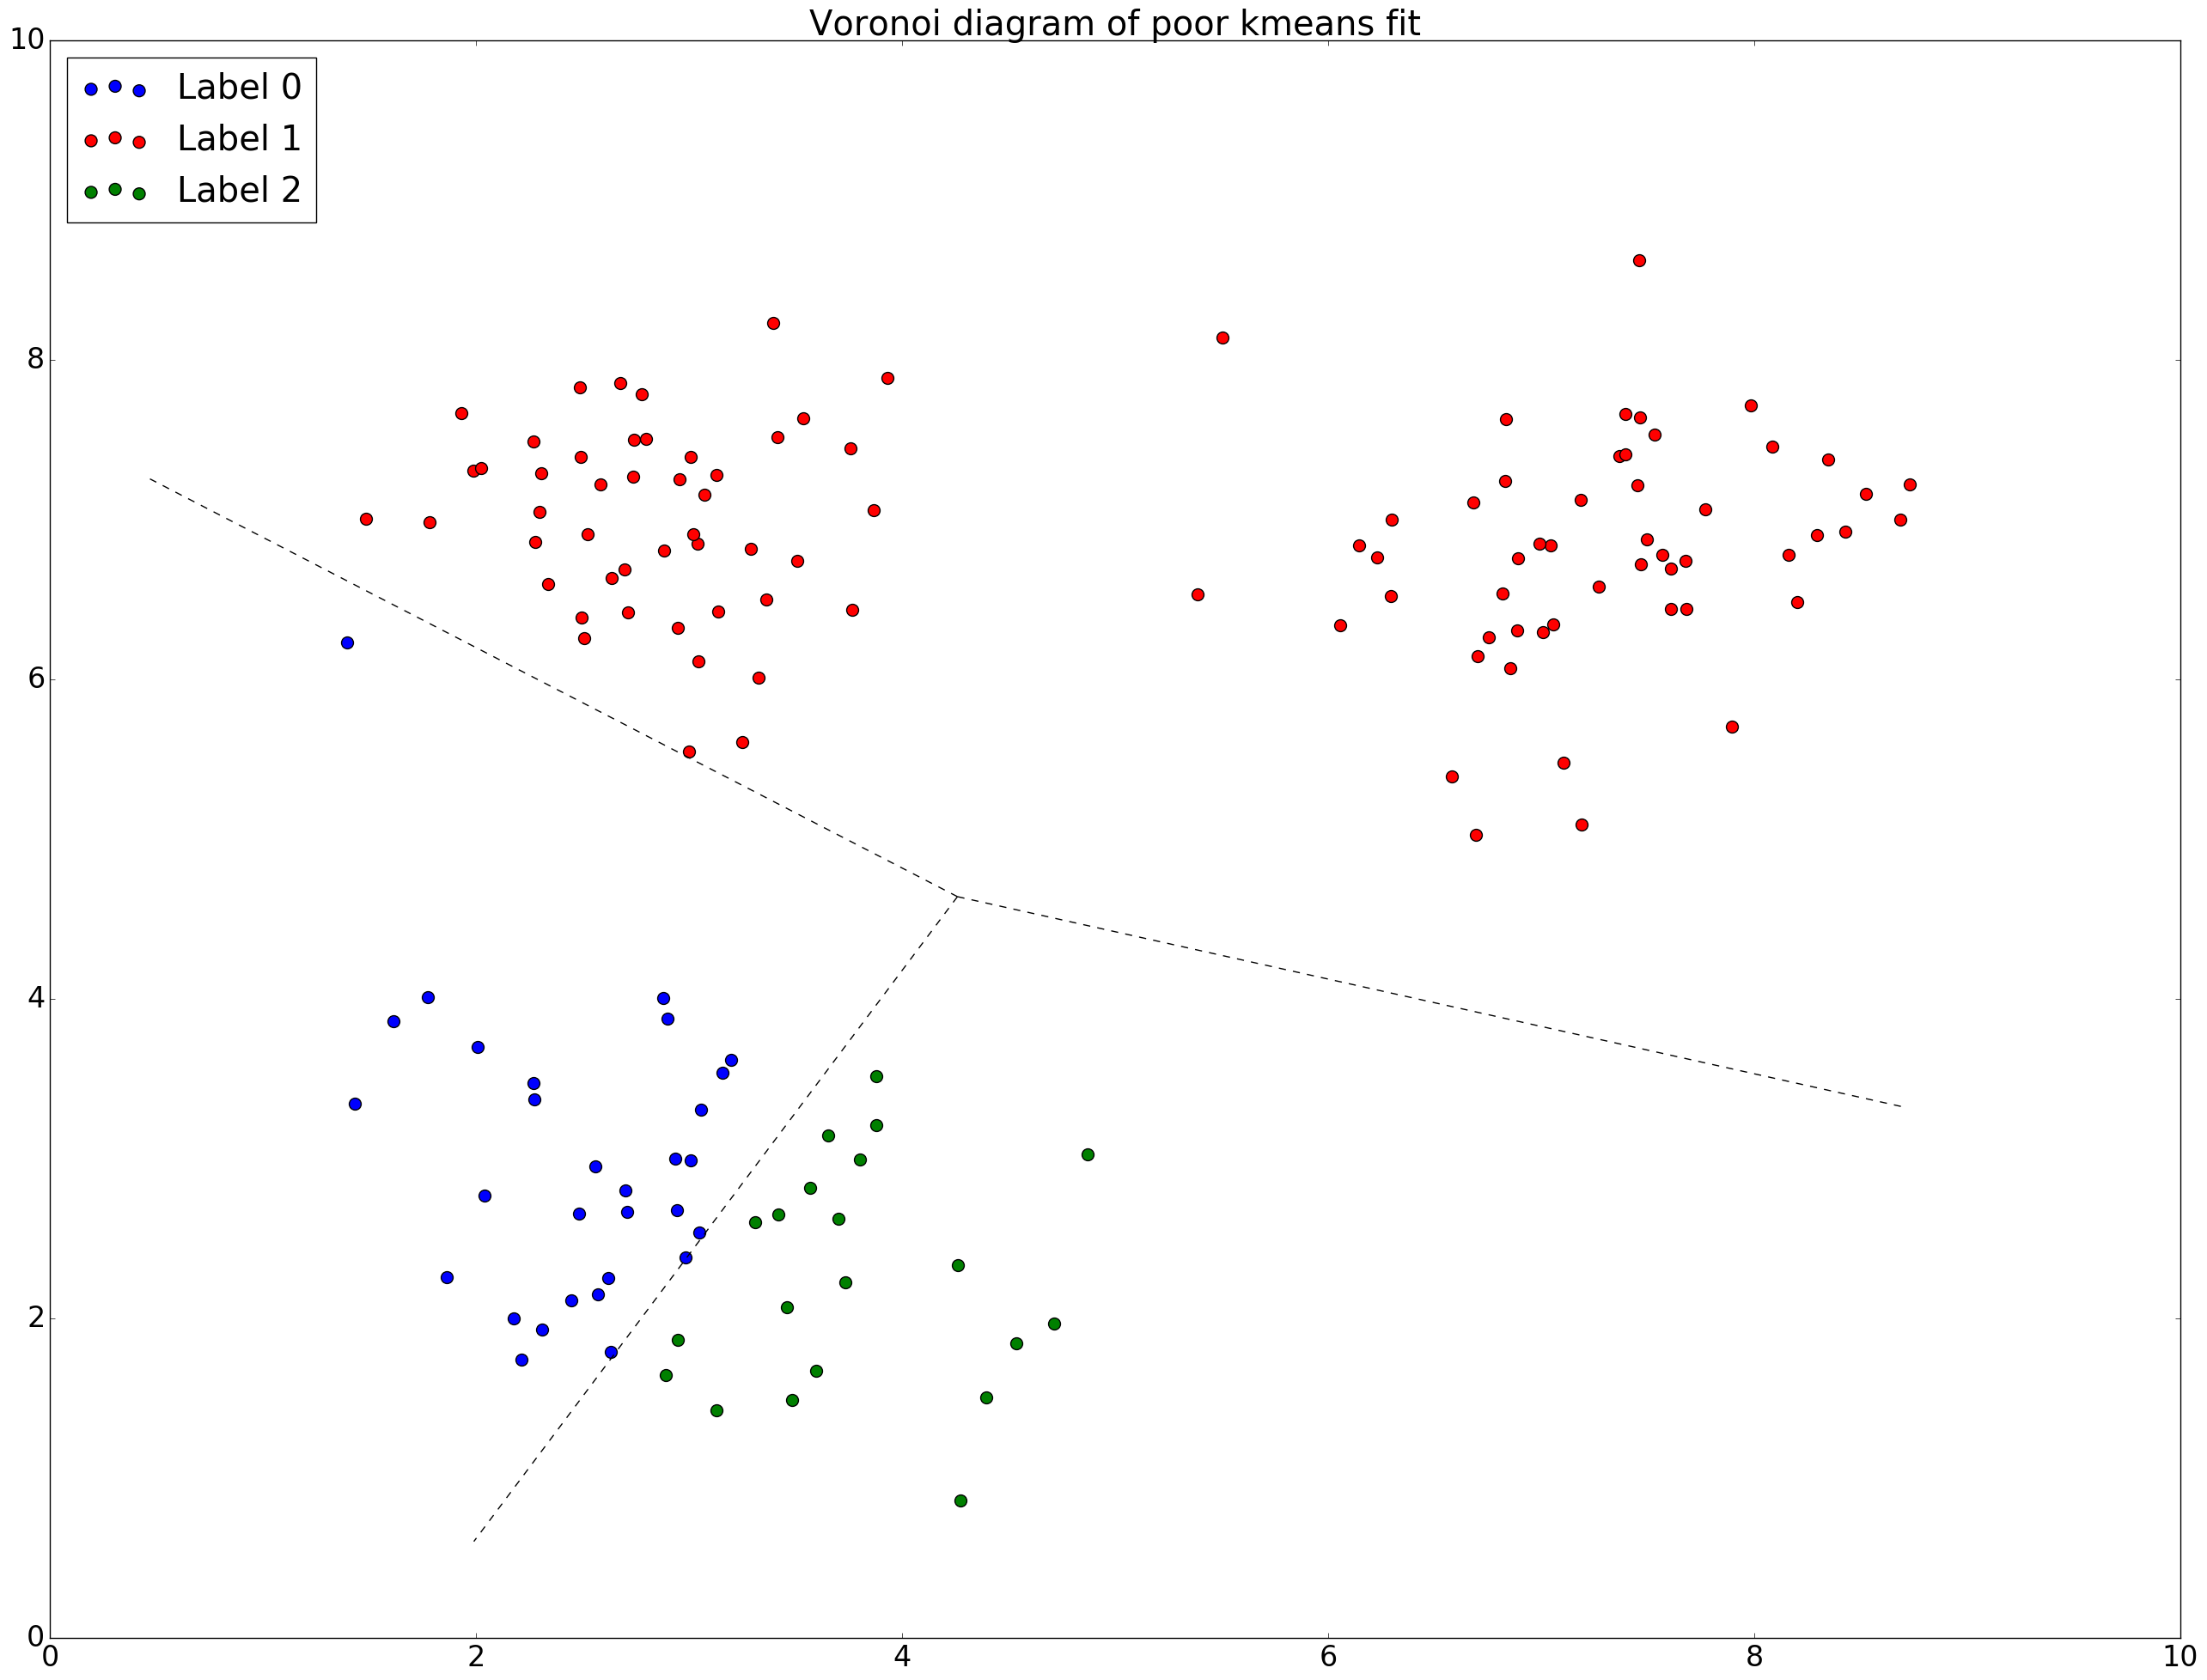

In [292]:
# Calculates a poor kmeans fit
def poor_kmeans(Data, NClusters, max_iterations=100):
    worst_sum = 0
    worst_fit = None
    for i in range(max_iterations):
        km = KMeans(NUM_OF_CLUSTERS, n_init=1, init='random')
        fitted = km.fit(X)
        
        if fitted.inertia_ > worst_sum: # TODO is this right?
            worst_sum = fitted.inertia_
            worst_fit = fitted
    
    return (worst_fit.cluster_centers_, worst_fit.labels_, worst_fit.inertia_)
     
X_bad_cluster_centers, X_bad_labels, X_bad_inertia = poor_kmeans(X, NUM_OF_CLUSTERS)    

X_bad_labeld = split_labels(X, X_bad_labels)

fig, ax = plt.subplots()

# Add voronoi diagrams
vor = Voronoi(X_bad_cluster_centers)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='black')

# Plot each label 
for label, P in X_bad_labeld.items():
    ax.scatter(P[:,0], P[:,1], c=COLOURS[label], s=100, label='Label %i' % label)
  
    
plt.autoscale(True, tight=False)        
plt.title('Voronoi diagram of poor kmeans fit')
plt.legend(loc='upper left')

plt.show()

### Your comments ###

TODO

## CW1b (week 18) ##
The simple nearest-centroid classifier you constructed in the previous assignment leads to linear decision boundaries between each pair of classes, as visualised by the Voronoi diagram. We now want you to contrast and compare this with a maximum-likelihood classifier.

### 1. ###
Model the data in each class as being generated from a 2-D Normal Distribution. Estimate the class means and covariances from the labelled training data using the `np.mean` (remember about `axis` parameter) and `np.cov` functions. Visualise the estimated distributions by plotting contours of the `stats.multivariate_normal.pdf` functions of each class. Choose the contour level such that 95% of the probability mass is within the ellipse. Use as a starting point that for bivariate random distributions the points on this contour satisfy the equation
$$ (x-\mu)^{T} * \Sigma^{-1} * (x-\mu) / 2 = 3 $$
and use this to find the appropriate density for the contour level. `Python` functions to use include `plt.contour` and `np.meshgrid`.

**Clarification:** this basically tells you to draw an ellipse at squared Mahalanobis distance 6. Why 6 (actually 5.99)? This comes from the fact that sums of squared Gaussians follow a Chi-squared distribution, so we use the inverse of the Chi-squared cumulative distribution with 2 degrees of freedom. You can verify this in `Python` by the query `stats.chi2.ppf(0.95, 2)` which gives 5.9915. This is the 2-D equivalent of saying that in 1-D, 95% of the Gaussian probability mass is within +/- 2 standard deviations from the mean (actually 1.96). More information at the following links:  
* [http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/](http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/)
* [http://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall06/reading/gaussians.pdf](http://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall06/reading/gaussians.pdf)

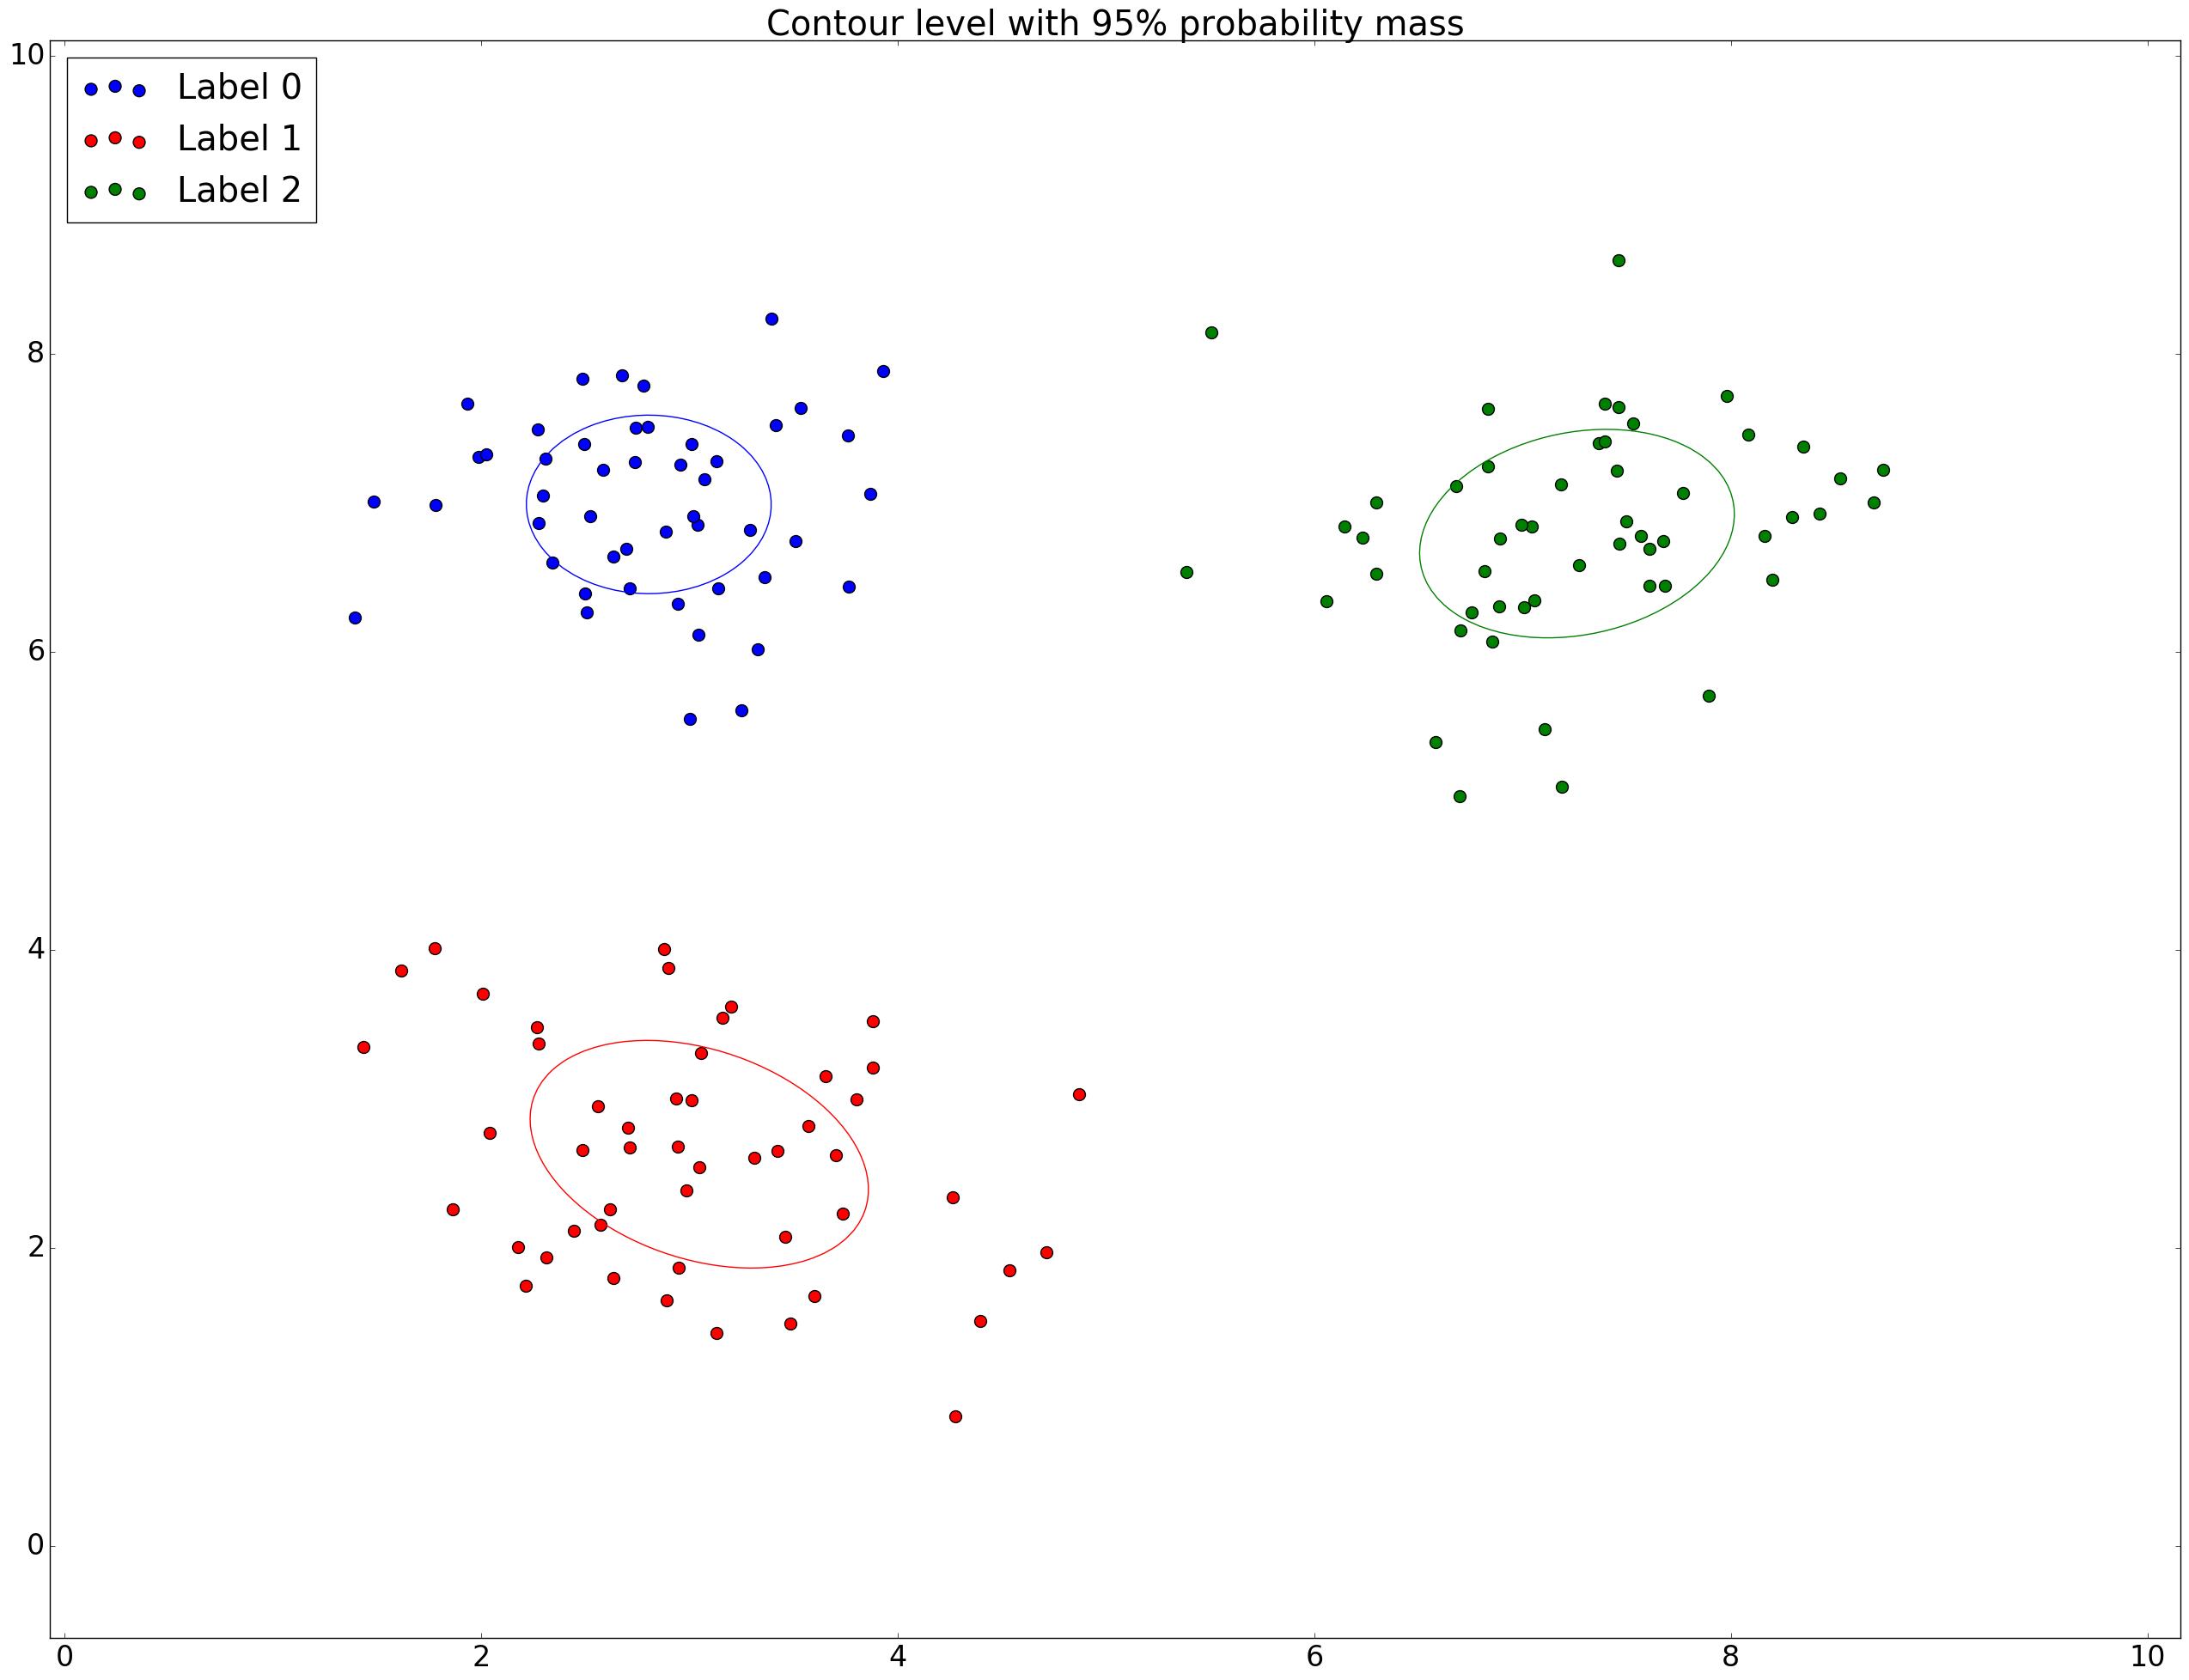

In [350]:
from matplotlib.mlab import bivariate_normal

# TODO Get help on this
mahal_dist = stats.chi2.ppf(0.95, 2);

fig, ax = plt.subplots()

def find_point_at_mahal_dist(mahal_dist, mu, sigma):
    #mahal_dist([mu[0], y], mu, sigma)^2 == squared_mahal_dist # Find y
    
    # Hand solved matrix
    d = (1.0 / np.linalg.det(sigma)) * sigma[0,0]
    a = d
    b = d * -2.0*mu[1]
    c = d * np.power(mu[1], 2)
    r = np.roots([c, b, a])
    
    print r
    
    return [mu[0], r[0]]

X_pd_mesh = {}

# Create a grid to store the results in
x_min, y_min = np.min(X[:,0])-1, np.min(X[:,1])-1
x_max, y_max = np.max(X[:,0])+1, np.max(X[:,1])+1
x, y = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

sample_mesh = np.empty(x.shape + (2,))
sample_mesh[:, :, 0] = x; sample_mesh[:, :, 1] = y

for label, P in X_labeld.items():
    # Calculate mean and covariance
    mu = np.mean(P, axis=0)
    sigma = np.cov(P, rowvar=False)
        
    # Setup our random varible
    P_rv = stats.multivariate_normal(mean=mu, cov=sigma)
    
    P_pd_mesh = P_rv.pdf(sample_mesh)
    X_pd_mesh[label] = P_pd_mesh
    
    # Calculate contour level containg 95% probability mass
    # TODO I don't think this is right
    #boundry_point = find_point_at_mahal_dist(mahal_dist, mu, sigma)
    #boundry_prob_density = rv.pdf(boundry_point)
    #levels = [boundry_prob_density]
    #print boundry_point
    #print boundry_prob_density
    
    levels = [(0.5 / (np.pi * np.sqrt(np.linalg.det(sigma)))) * np.exp(-0.5)]
    
    # Plot points and contours
    ax.contour(x, y, P_pd_mesh, levels=levels, colors=COLOURS[label])
    ax.scatter(P[:,0], P[:,1], c=COLOURS[label], s=100, label='Label %i' % label)
    
plt.title('Contour level with 95% probability mass')
plt.legend(loc='upper left')
    
plt.show()

### Your comments ###

Put here any comments

### 2. ###
Now plot the decision boundaries between each pair of classes. This can be done once again using the `plt.contour` function, this time on each of the three pairwise likelihood ratios. Visually inspect the decision boundaries and make sure you understand why they have a particular shape. Also check whether this maximum-likelihood classifier disagrees with the nearest-centroid classifier on any of the test or training points (for both your data sets if you're working in pairs).

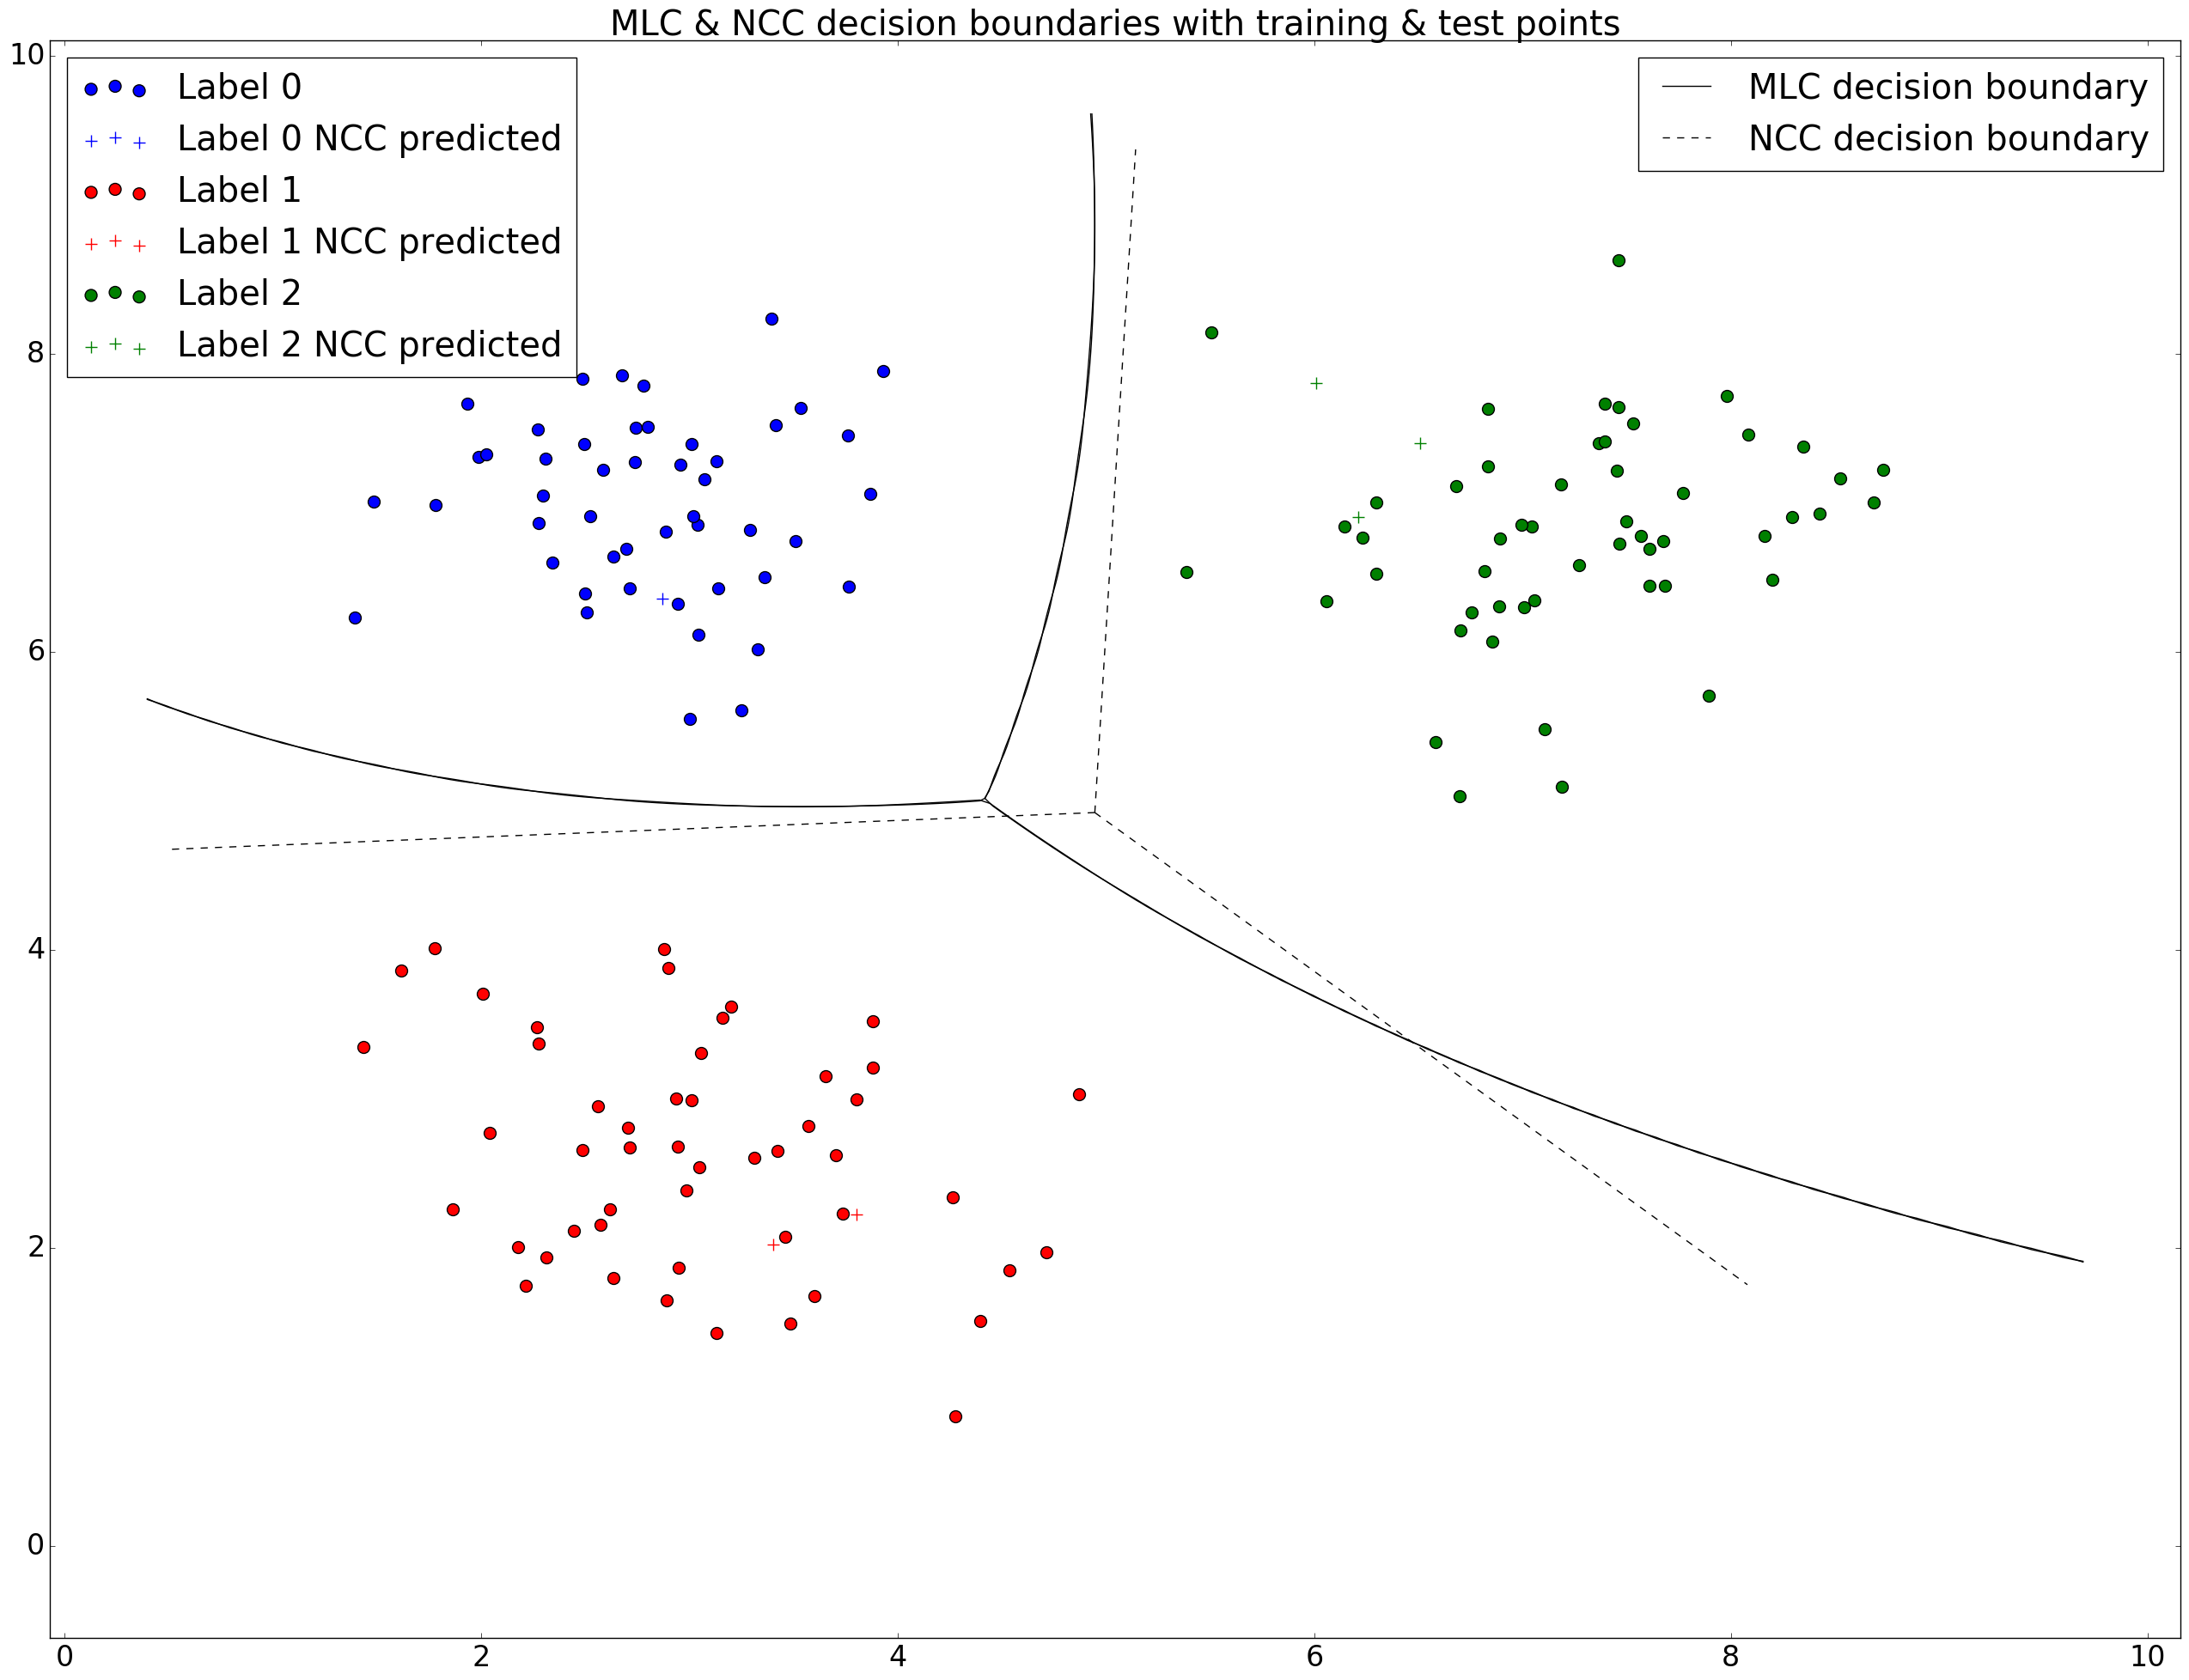

In [351]:
fig, ax = plt.subplots()

for label, pd_mesh in X_pd_mesh.items():
    # calculate lilelihood ratios
    other_pd_meshs = list(X_pd_mesh.values())
    other_pd_meshs.pop(label)
    likelihood_ratios = pd_mesh / np.maximum(other_pd_meshs[0], other_pd_meshs[1])
        
    # Plot decision boundaries
    ax.contour(x, y, likelihood_ratios, levels=[1], colors='black')
    
    # Train and test points
    ax.scatter(X_labeld[label][:,0], X_labeld[label][:,1], c=COLOURS[label], s=100, label='Label %i' % label)
    ax.scatter(Y_labeld[label][:,0], Y_labeld[label][:,1], marker='+', c=COLOURS[label], s=100, label='Label %i NCC predicted' % label)

# Add voronoi diagrams
vor = Voronoi(X_cluster_centers)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='black')

plt.autoscale(True, tight=True)        
plt.title('MLC & NCC decision boundaries with training & test points')

# Custom legend for decision boundaries
point_legend = plt.legend(loc='upper left')
plt.gca().add_artist(point_legend)
mlc_legend_artist = plt.Line2D([0], [0], color='black')
ncc_legend_artist = plt.Line2D([0], [0], color='black', linestyle='dashed')
plt.legend([mlc_legend_artist, ncc_legend_artist], ['MLC decision boundary', 'NCC decision boundary'])

# TODO show that there are no disagreements

plt.show()

### Your comments ###

Put here any comments

### 3. ###
How would you have to change the maximum-likelihood classifier so that its decision boundaries are the same as the ones for nearest-centroid? And how would you change it if you know that one of the three classes is twice as likely as the other two? Demonstrate the effect graphically.

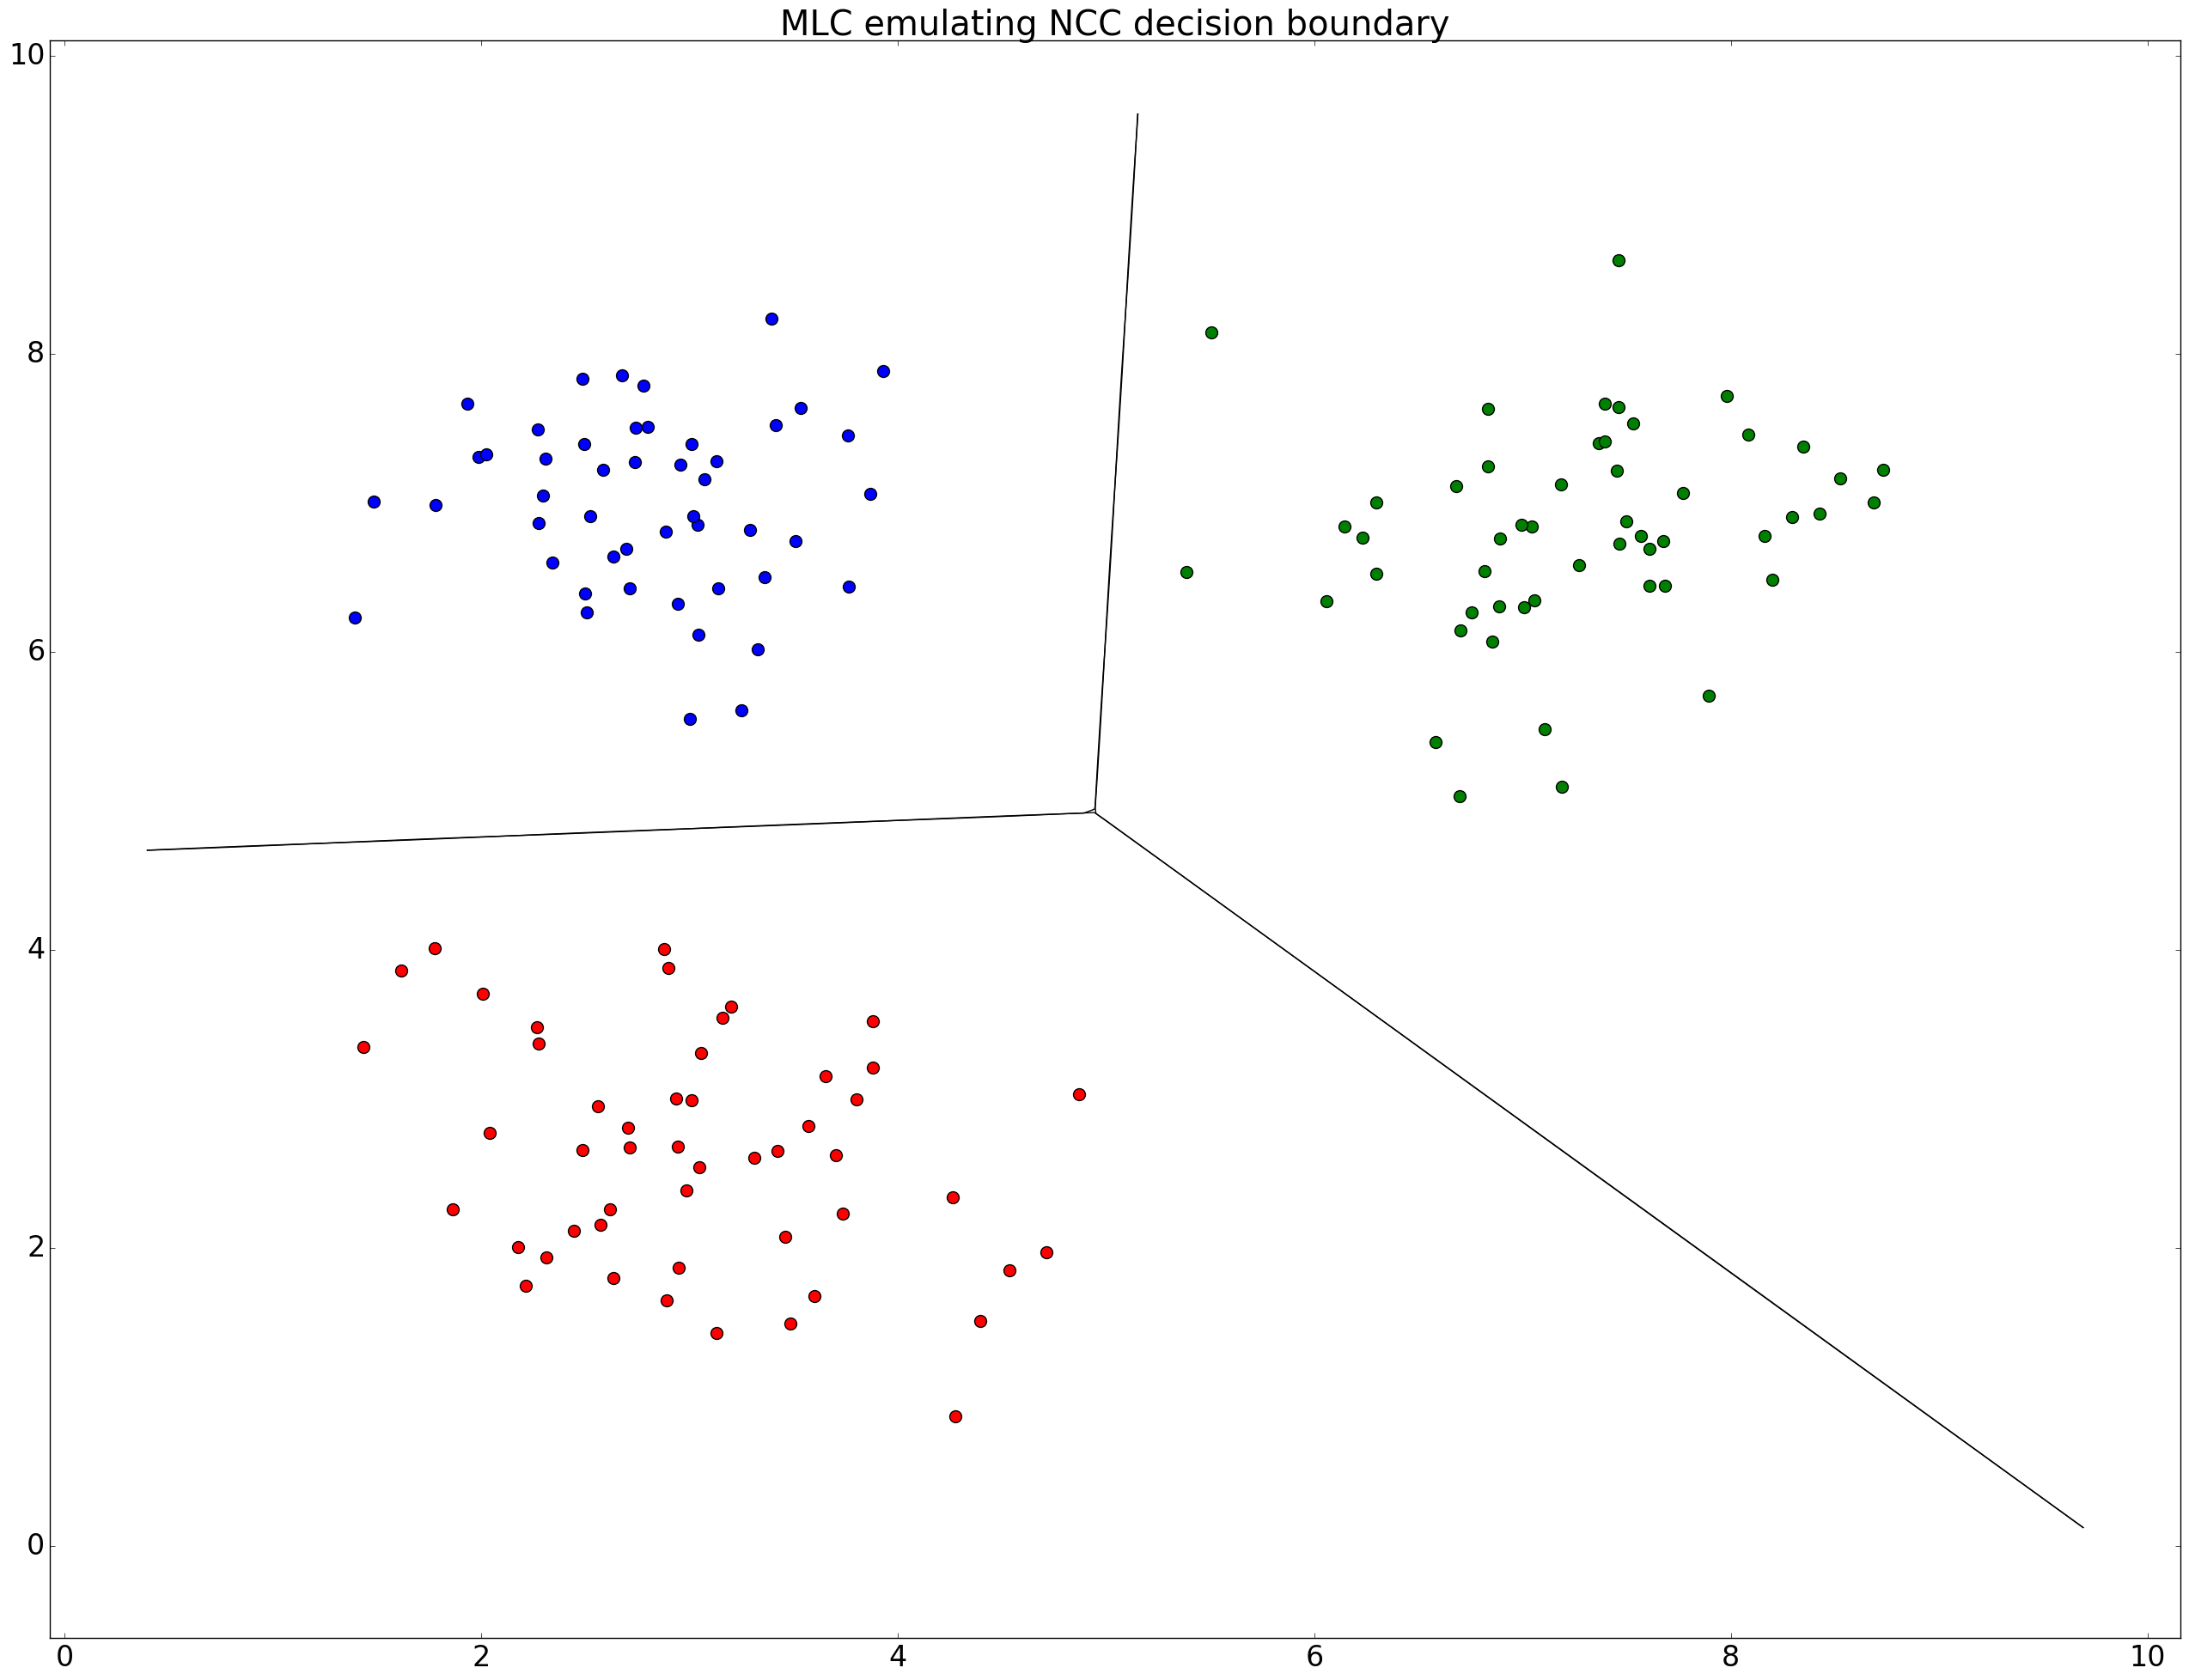

In [325]:
fig, ax = plt.subplots()

X_emulate_ncc_pd_mesh = {}

for label, P in X_labeld.items():
    # Set covariance equal to identiy matrix
    sigma = np.identity(2) 
    
    # Calculate mean
    mu = np.mean(P, axis=0)
        
    # Setup our random varible
    P_rv = stats.multivariate_normal(mean=mu, cov=sigma)
    
    P_pd_mesh = P_rv.pdf(sample_mesh)
    X_emulate_ncc_pd_mesh[label] = P_pd_mesh

for label, pd_mesh in X_emulate_ncc_pd_mesh.items():
    # calculate lilelihood ratios
    other_pd_meshs = list(X_emulate_ncc_pd_mesh.values())
    other_pd_meshs.pop(label)
    likelihood_ratios = pd_mesh / np.maximum(other_pd_meshs[0], other_pd_meshs[1])
        
    # Plot decision boundaries
    ax.contour(x, y, likelihood_ratios, levels=[1], colors='black')
    
    # Plot points
    ax.scatter(X_labeld[label][:,0], X_labeld[label][:,1], c=COLOURS[label], s=100, label='Label %i' % label)

plt.title('MLC emulating NCC decision boundary')
plt.show()

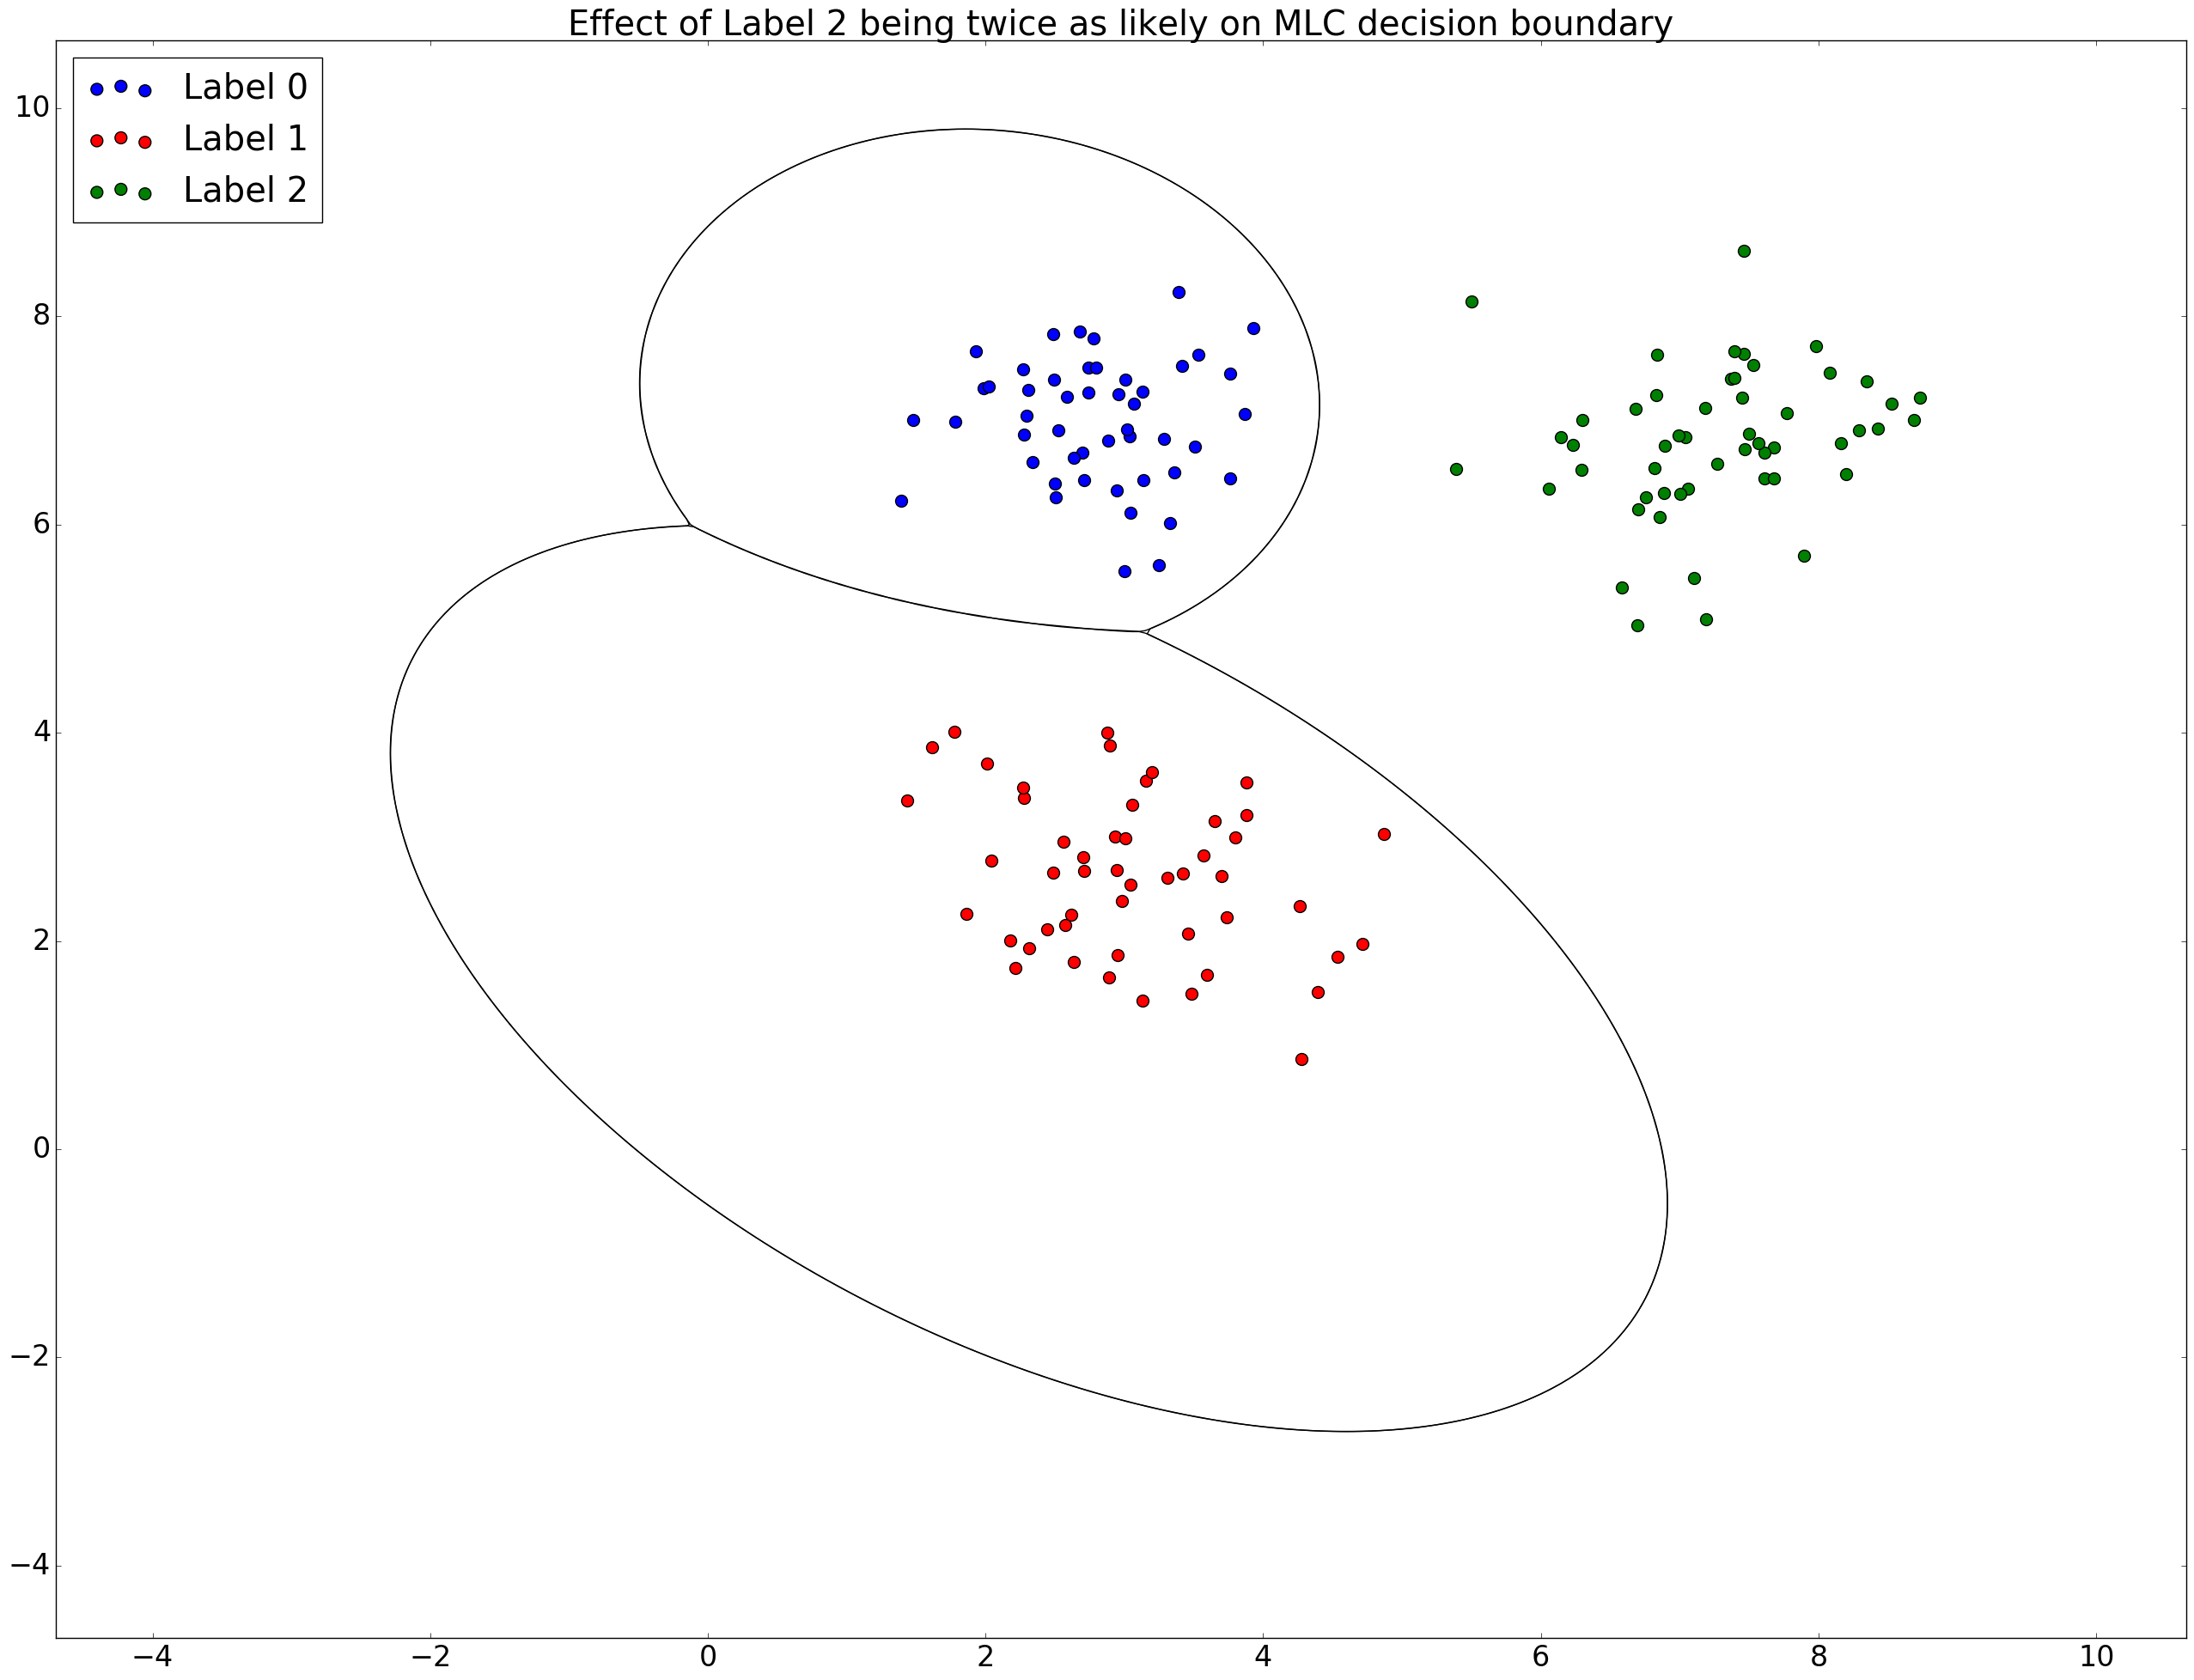

In [347]:
fig, ax = plt.subplots()

# Create a larger grid to store the results in
x, y = np.meshgrid(np.arange(-4, 10, 0.05), np.arange(-4, 10, 0.05))
sample_mesh = np.empty(x.shape + (2,))
sample_mesh[:, :, 0] = x; sample_mesh[:, :, 1] = y

X_twice_likely_pd_mesh = {}

label_twice_likely = 2

for label, P in X_labeld.items():
    # Calculate covariance, set single class twice as likely as others
    sigma = np.cov(P, rowvar=False)
    if label == label_twice_likely:
        sigma *= 4        
    
    # Calculate mean
    mu = np.mean(P, axis=0)
        
    # Setup our random varible
    P_rv = stats.multivariate_normal(mean=mu, cov=sigma)
    
    P_pd_mesh = P_rv.pdf(sample_mesh)
    X_twice_likely_pd_mesh[label] = P_pd_mesh

for label, pd_mesh in X_twice_likely_pd_mesh.items():
    # calculate lilelihood ratios
    other_pd_meshs = list(X_twice_likely_pd_mesh.values())
    other_pd_meshs.pop(label)
    likelihood_ratios = pd_mesh / np.maximum(other_pd_meshs[0], other_pd_meshs[1])
        
    # Plot decision boundaries
    ax.contour(x, y, likelihood_ratios, levels=[1], colors='black')
    
    # Plot points
    ax.scatter(X_labeld[label][:,0], X_labeld[label][:,1], c=COLOURS[label], s=100, label='Label %i' % label)

plt.legend(loc='upper left')
plt.autoscale(True, tight=True) 
plt.title('Effect of Label %i being twice as likely on MLC decision boundary' % label_twice_likely)
plt.show()

### Your comments ###

Put here any comments



## CW1c (week 19) ##
You now need to write a report which describes, explains and analyses the work you have done for **CW1a** and **CW1b**. The aim of this report is to demonstrate your understanding of methods you used and the results that you have obtained. This will be useful training for the CW2 assignment which is entirely assessed through a report.

As this is not a `Python` programming assignment you are not allowed to use any `Python` code in your report. So, rather than "The program then calls `kmeans(data,3)` and stores the result in `some_var`" you should write something like "we then applied K-means clustering to this data set to obtain K=3 clusters".

The report should be **no more than 4 pages long using no less than 11 point font** and should be submitted in `pdf` format on SAFE. You will continue to work in pairs and at least one of you should upload the report. Make sure that the submitted report clearly identifies the authors.

We suggest you use the following headings in the report (but this is not prescriptive):
1. Introduction
2. Feature selection
3. Identifying the classes
4. Nearest-centroid classification
5. Maximum-likelihood classification
6. Discussion of results
7. Sources used

Notice how these sections don't map one-to-one to the questions above, but rather concentrate on telling a 'story'. In each section you should briefly explain what the question is, how you approached it and what the results are. We will expect you to include plots generated by `Python`, but these should not take more than about *one-third of the report*. Each plot should have a numbered caption with a succinct description. You need to include plots for both datasets assigned to you and your partner.

**To gain high marks your report will need to demonstrate a good understanding of the tasks and the methods used, backed up by a clear explanation of your experimental results.**